# Monk1 
Grid Search for Monk1 dataset model selection


In [3]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out
from exclusiveAI.components.Validation.KFoldCrossValidation import validate
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.mlcup import read_cup_training_dataset, read_cup_test_dataset
from exclusiveAI.Composer import Composer
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk1 dataset 

In [4]:
file_path = "MLCup/Data/training_data_split.json"
# Load training and test data from the JSON file
with open(file_path, 'r') as jsonfile:
    data_dict = json.load(jsonfile)

training_data = np.array(data_dict['training_data'])
training_labels = np.array(data_dict['training_labels'])
test_data = np.array(data_dict['test_data'])
test_labels = np.array(data_dict['test_labels'])
train_idx = np.array(data_dict['train_idx'])
test_idx = np.array(data_dict['test_idx'])

In [5]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()][1]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 200
epochs = 1000

final_path = 'MLCup_models_configs1520.json'

if not os.path.exists(final_path):
    dir_path = "MLCup/"
    
    all_json_data = read_json_files(dir_path)
    # Get the top 3 most common values
    # regularizations = all_json_data['regularization'].unique().tolist()
    regularizations = [1e-6, 1e-7, 1e-8]
    learning_rates = [0.001, 0.0005]
    momentums = [0.5]
    num_of_layers = [2]
    # num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    num_of_units = [15, 20]
    initializers = all_json_data['initializers'].unique().tolist()
    activations = ['tanh', 'sigmoid']

    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=False, outputs=3,
                                     callbacks=["earlystopping"], output_activation='linear', show_line=False,
                                     ).get_configs()
    print(len(myConfigurator))
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs, return_models_history=True,
                              batch_size=batch_size, num_models=100, number_of_initializations=2, regression=True,
                              ))

        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_path)
with open(final_path, 'r') as f:
    configs = [data['0'] for data in json.load(f).values()]

In [6]:
my_configs = []
for config in configs[1]:
    config['callbacks'] = ['earlystopping_1e-2_20']
if __name__ == '__main__':
    my_configs.append(
        validate(configs[1], x=training_data, y_true=training_labels, epochs=epochs, return_models_history=True,
                          batch_size=batch_size, max_configs=100, number_of_initializations=2, n_splits=4
                          ))

configs=my_configs[0]
old_history = configs[0][0]
my_config=configs[1][0]

Models: 100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


In [7]:
model = Composer(config=my_config).compose(regression=True)
model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=my_config['model_name'], disable_line=False)
test_val = model.evaluate(input=test_data, input_label=test_labels, metrics=['mse', 'mee'])
results = [(model.get_last()['mse'], np.std(np.array(model.history['mee'])), model.get_last()['mee'], test_val[0], test_val[1], model.curr_epoch, model.best_epoch, np.min(old_history['mee']),  np.min(old_history['val_mee']), old_history['mee'],  old_history['val_mee'], model.history['mee'], Composer(config=my_config).compose(), my_config, my_config['num_layers'], my_config['num_of_units'], my_config['model_name'])]
# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(results, columns=['Score', 'History_Std', 'Mee', 'Test_Score', 'Test_Mee', 'Trained_Epochs', 'Old_Best_Epochs', 'Old_History_Last', 'Old_History_val_Last', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

Model13: 100%|██████████| 1000/1000 [00:05<00:00, 187.49it/s, mse=1.4, mae=0.499, mee=1]     


In [8]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'Score', 'Test_Score', 'History_Std'])
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Mee,Test_Score,Test_Mee,Trained_Epochs,Old_Best_Epochs,Old_History_Last,Old_History_val_Last,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name
0,1.397994,3.153696,1.003756,2.660658,1.249307,1000,980,1.267745,1.178988,"[43.27135, 38.705177, 31.751118, 30.36578, 29....","[41.9178, 38.13457, 30.221714, 28.766592, 27.9...","[43.00705, 37.118855, 32.74269, 30.164097, 27....",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 1e-06, 'learning_rate': 0.0...",2,"[20, 20]",Model13


In [ ]:
plot_history(histories)
plot_history(old_history)

In [10]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array = np.array(row['History'])
        differences =  (np.diff(array) - np.mean(array)) /np.mean(array) 
        # differences =  (np.diff(array) / np.mean(array)) 
        min_consecutive_difference = np.min(differences)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
print(result_row['Config']) 
result_row.to_csv('MLCup_FirstTry.csv')

Selected row:
Score                                                            1.397994
History_Std                                                      3.153696
Mee                                                              1.003756
Test_Score                                                       2.660658
Test_Mee                                                         1.249307
Trained_Epochs                                                       1000
Old_Best_Epochs                                                       980
Old_History_Last                                                 1.267745
Old_History_val_Last                                             1.178988
Old_History             [43.27135, 38.705177, 31.751118, 30.36578, 29....
Old_History_val         [41.9178, 38.13457, 30.221714, 28.766592, 27.9...
History                 [43.00705, 37.118855, 32.74269, 30.164097, 27....
Model                   <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config                  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


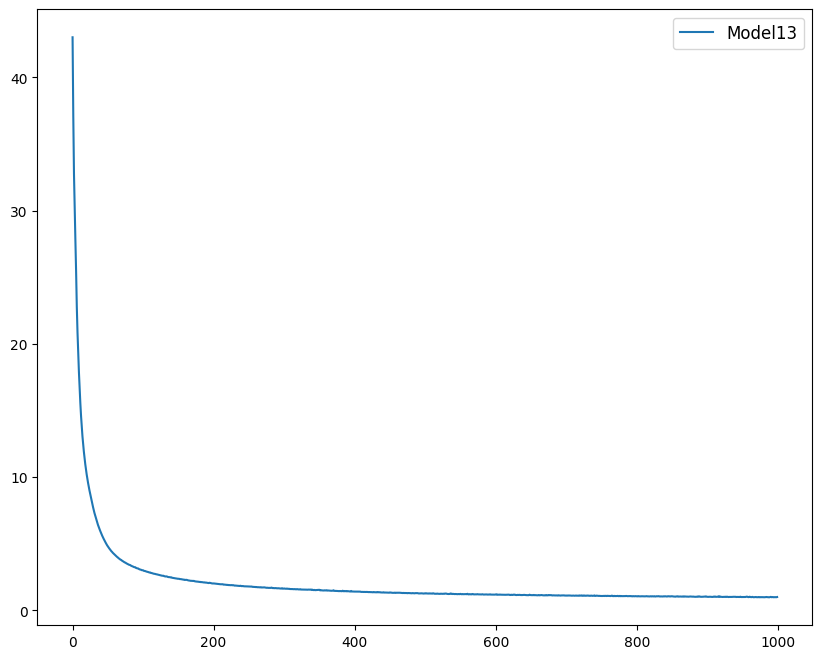

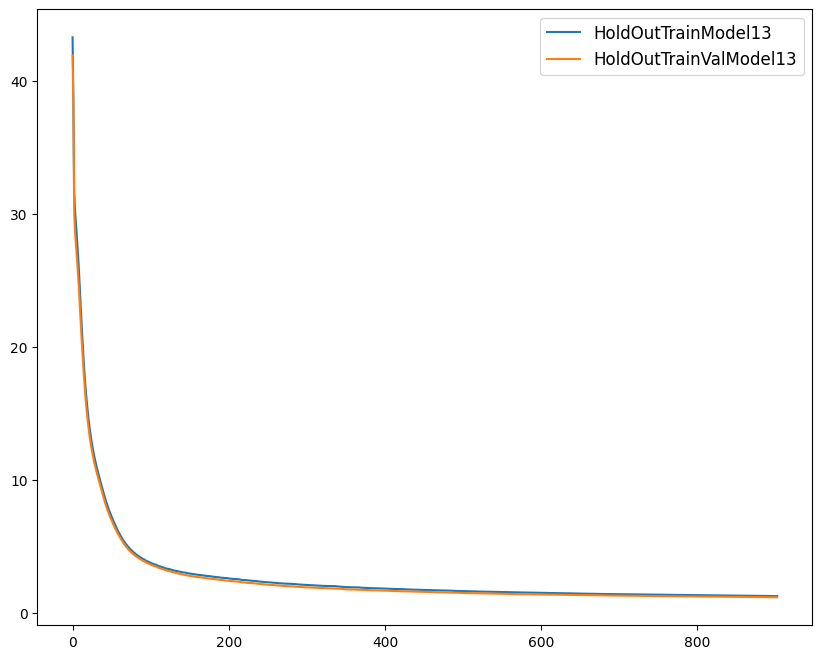

In [41]:
import matplotlib.pyplot as plt
def plot_history2(name, lines: dict, fig_size=(10, 6)):
    plt.figure(figsize=fig_size)
    for elem in lines:
        plt.plot(lines[elem], label=elem)
    plt.legend(fontsize=12)
    plt.savefig(name+'.eps', format='eps')
    plt.savefig(name+'.png', format='png')

plot_history2(name='MLCup_train', lines={result_row["Name"]: result_row['History']}, fig_size=(10,8))
plot_history2(name='MLCup_HoldOut', lines={'HoldOutTrain'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History'])), 'HoldOutTrainVal'+result_row["Name"]: -np.sort(-np.array(result_row['Old_History_val']))}, fig_size=(10,8))


In [38]:
full_dataset, full_dataset_labels = read_cup_training_dataset('../exclusiveAI/datasets')
results = validate(configs[1], x=full_dataset, y_true=full_dataset_labels, max_configs=1, n_splits=4, number_of_initializations=2, epochs=epochs, batch_size=batch_size, regression=True, return_models_history=True)
model_config = results[1]

model = Composer(config=model_config).compose(regression=True)
history = model.train(inputs=full_dataset, input_label=full_dataset_labels, epochs=epochs, batch_size=batch_size)
model.save('MLCup_model.h5')

Epochs: 100%|██████████| 1000/1000 [00:05<00:00, 169.34it/s, mse=1.49, mae=0.515, mee=1.04]


Epochs: 100%|██████████| 1000/1000 [00:48<00:00, 20.60it/s, mse=5.99, val_mse=8.07, mae=1.06, val_mae=1.17, mee=2.12, val_mee=2.36]    


{'regularization': 0, 'learning_rate': 0.001, 'loss_function': 'mse', 'activation_functions': ['tanh', 'sigmoid'], 'output_activation': 'linear', 'num_of_units': [50, 20], 'num_layers': 2, 'momentum': 0.5, 'optimizer': 'sgd', 'initializers': 'gaussian', 'nesterov': False, 'beta2': 0, 'input_shape': [750, 10], 'callbacks': [], 'verbose': False, 'outputs': 3, 'model_name': 'Model13', 'callback': []}


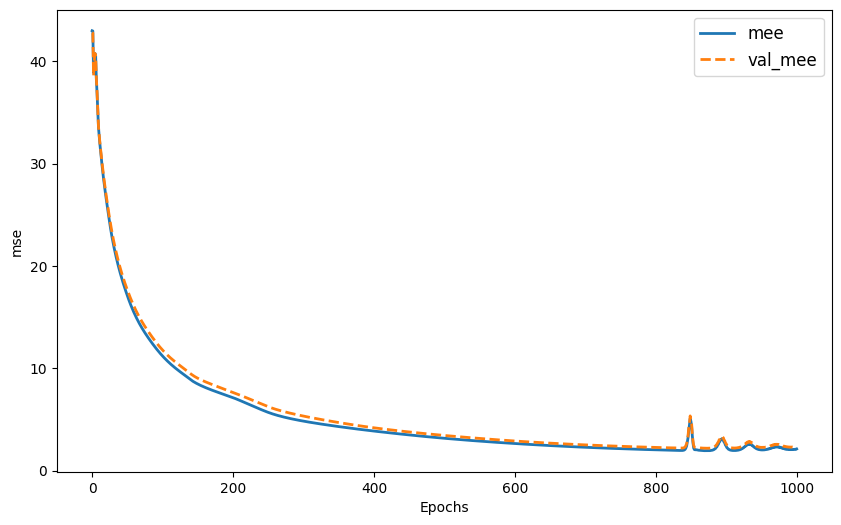

In [100]:
# histories = results[0]
# history_cv = {key: histories[key] for key in histories if 'mee' in  key}
# plot_history({key: history[key] for key in history if 'mee' in key})

In [102]:
from exclusiveAI.components.NeuralNetwork import NeuralNetwork
final_model = NeuralNetwork.load('MLCup_model.h5')
res = final_model.evaluate(test_data, test_labels, metrics=['mse', 'mee'])
print(res)

[1.6792632, 1.0836005]


In [105]:
test_dataset = read_cup_test_dataset('../exclusiveAI/datasets')
test_dataset
test_labels

array([[-1.93898760e+00, -7.43258600e+01,  2.81535630e+01],
       [ 8.15753900e+00,  1.26836760e+01,  1.91623250e+01],
       [-3.12855550e+01,  7.37779140e-01,  5.55265900e+00],
       [-7.88348400e+01, -8.09522500e+00,  4.55470850e+00],
       [ 4.13386400e+00, -5.03645860e+01,  3.39883400e+01],
       [-3.41679570e+01, -5.03161500e+01,  3.79051690e+00],
       [-3.52268900e+01, -4.50614470e+01,  1.63495270e+01],
       [ 3.49153540e+00, -2.49922440e+00,  2.01482120e+01],
       [-1.10884030e+01,  9.74740600e+00,  1.88496630e+01],
       [-1.44809410e+01,  7.08594940e+00,  2.46427560e+01],
       [-7.67949100e+00,  1.12711920e+01,  1.86800750e+01],
       [-4.87955320e+01, -1.78340840e+01,  4.15601600e+00],
       [-6.72880000e+01,  9.09746940e-01,  1.13649410e+01],
       [-5.89447450e+00, -6.79033360e+01,  3.20559740e+00],
       [-6.71763840e+01,  2.86102460e+00,  1.71689470e+01],
       [ 8.03874400e+00, -2.25008170e-01,  1.42740580e+00],
       [-6.74339300e+01,  8.02322100e+00

In [104]:
predictions = final_model.predict(test_dataset)

df = pd.DataFrame(predictions)
df.to_csv("./final_prediction.csv", float_format='%.16f', index=True, header=False)